<div class="alert alert-block alert-success">
    
# FIT5201 Task 4
#### Student Name: Mohammed Hasan Uddin Quraishi
#### Student ID: 31064191
    
</div>

<div class="alert alert-block alert-danger">
    
## Table of Contents

</div>    

[4 Logistic Regression versus Bayes Classifier](#q4)<br>
$\;$[Question 7 Discriminative vs Generative Models](#disgen) <br>
$\;\;\;$[I Implement Load Test](#loadtest) <br>
$\;\;\;$[II Test the performance for increasing training sizes](#tesincrease) <br>
$\;\;\;$[III Create Plot](#tesincrease) <br>
$\;\;\;$[IV Formulate answers to the questions](#form) <br>

<div class="alert alert-block alert-warning">

#### Question 4 Bayes Rule <a class="anchor" name="q4"></a>
    
</div>


<div class="alert alert-block alert-warning">

#### I Load the breast cancer dataset via load breast cancer in sklearn.datasets, importLogisticRegression from sklearn.linear model, and copy the code from Activity 3.3.for the Bayes classifier (BC). For the Bayes classifier consider the Naive Bayes variant (without shared covariance) as well as the variants with full covariance (shared and not shared).Perform a training/test split (with train size equal to 0.8) and report which of the models performs best in terms of train and test performance.
 <a class="anchor" name="loadtest"></a>
    
</div>

Loading the breast cancer dataset via load breast cancer in sklearn.datasets, import
LogisticRegression from sklearn.linear model

In [19]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [20]:
breast_cancer = load_breast_cancer()
breast_cancer.data.shape, breast_cancer.target.shape, breast_cancer.feature_names, breast_cancer.target_names

((569, 30),
 (569,),
 array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
        'mean smoothness', 'mean compactness', 'mean concavity',
        'mean concave points', 'mean symmetry', 'mean fractal dimension',
        'radius error', 'texture error', 'perimeter error', 'area error',
        'smoothness error', 'compactness error', 'concavity error',
        'concave points error', 'symmetry error',
        'fractal dimension error', 'worst radius', 'worst texture',
        'worst perimeter', 'worst area', 'worst smoothness',
        'worst compactness', 'worst concavity', 'worst concave points',
        'worst symmetry', 'worst fractal dimension'], dtype='<U23'),
 array(['malignant', 'benign'], dtype='<U9'))

Copy the code from Activity 3.3. for the Bayes classifier (BC)

In [21]:
from scipy.stats import multivariate_normal

class BayesianClassifier:

    def __init__(self, shared_cov=True, cond_ind=True):
        self.shared_cov=shared_cov
        self.cond_ind=cond_ind

    def fit(self, x, y):
        self.classes_, class_counts = np.unique(y, return_counts=True)
        self.n_ , self.p_ = x.shape
        self.k_ = len(self.classes_)
        self.cond_means_ = np.zeros(shape=(self.k_, self.p_))
        self.cond_covs_ = np.zeros(shape=(self.k_, self.p_, self.p_))

        self.class_priors_ = class_counts/len(y)
        for c in range(self.k_):
            c_rows = y==c
            self.cond_means_[c, :] = x[c_rows].mean(axis=0)
            if self.cond_ind:
                np.fill_diagonal(self.cond_covs_[c, :, :], x[c_rows].var(axis=0))
            else:
                self.cond_covs_[c, :, :] = np.cov(x[c_rows].T, bias=True)

        if self.shared_cov:
            shared_cov = np.moveaxis(self.cond_covs_, 0, -1).dot(self.class_priors_)
            self.cond_covs_[:] = shared_cov

        return self

    def predict_proba(self, x):
        m, _ = x.shape
        cond_probs = np.zeros(shape=(m, self.k_))
        for c in range(self.k_):
            # find p(x | c_k)
            # singular covariance matrices could happen (e.g., through inaccurate estimation)
            cond_probs[:, c] = multivariate_normal.pdf(x,
                                                       self.cond_means_[c],
                                                       self.cond_covs_[c],
                                                       allow_singular=True)
        # find marginal probabilities p(x) by summing all the conditionals weighted by the priors
        marginal_probs = cond_probs.dot(self.class_priors_)

        # find probability vector (p(c1 | x), ..., p(ck | x)) via p(ci | x)=p(x | ci) / p(x)
        # however, p(x) might have been rounded to 0
        # thus, compute via case distinction
        probs = np.divide((cond_probs*self.class_priors_).T,
                          marginal_probs,
                          where=marginal_probs>0, out=np.zeros(shape=(self.k_, m))).T
        return probs

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

    def decision_function(self, x):
        probs = self.predict_proba(x)
        if self.k_ == 2:
            return np.log(probs[:, 1]/probs[:, 0])
        else:
            res = np.zeros(len(x), self.k_)
            for c in range(self.k_):
                res[:, c]=np.log(probs[:, c]/(1-probs[:, c]))
            return res

    def generate(self, n, c, random_state=None):
        return multivariate_normal.rvs(self.cond_means_[c], self.cond_covs_[c], size=n, random_state=random_state)

Split dataset into train and test

In [22]:
def train_test_split(x, y, train_size=0.6, random_state=None):
    RNG = np.random.default_rng(random_state)
    N = len(x)
    N_train = round(N*train_size)
    idx_train = RNG.choice(N, N_train, replace=False)
    idx_test = np.setdiff1d(np.arange(N), idx_train)
    RNG.shuffle(idx_test)
    return x[idx_train], x[idx_test], y[idx_train], y[idx_test]

Split based on trainsize equal to 0.8

In [23]:
import numpy as np
breast_cancer_x_train, breast_cancer_x_test, breast_cancer_y_train, breast_cancer_y_test = train_test_split(breast_cancer.data, breast_cancer.target, train_size=0.8)

For the Bayes classifier consider the Naive Bayes variant (without shared covariance) as well as the variants with full covariance (shared and not shared).

Naive Bayes can be set using cond_ind and shared covariance can be set using shared_cov

In [24]:
#Naive bayes shared
nb_shared = BayesianClassifier(shared_cov=True, cond_ind=True).fit(breast_cancer_x_train, breast_cancer_y_train)
#Naive bayes full
nb = BayesianClassifier(shared_cov=False, cond_ind=True).fit(breast_cancer_x_train, breast_cancer_y_train)
#Bayes Shared
bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False).fit(breast_cancer_x_train, breast_cancer_y_train)
#Bayes Full
bc = BayesianClassifier(shared_cov=False, cond_ind=False).fit(breast_cancer_x_train, breast_cancer_y_train)
#Logistic Regression
log = LogisticRegression(max_iter = 10000).fit(breast_cancer_x_train, breast_cancer_y_train)

In [25]:
len(breast_cancer_x_train)

455

We us the plot model performance to compute best performance for both train and test dataste

In [26]:
from sklearn.metrics import zero_one_loss, log_loss

def plot_model_performances(models, model_names, x_train, x_test,  y_train,y_test):
    train_01_losses = []
    train_log_losses = []
    test_01_losses = []
    test_log_losses = []

    for i, model in enumerate(models):
        train_01_losses.append(zero_one_loss(y_train, model.predict(x_train)))
        train_log_losses.append(log_loss(y_train, model.predict_proba(x_train)))
        test_01_losses.append(zero_one_loss(y_test, model.predict(x_test)))
        test_log_losses.append(log_loss(y_test, model.predict_proba(x_test)))
    print(f'The best model that has the lowest log loss value for the training set is {model_names[train_log_losses.index(min(train_log_losses))]}.')
    print(f'The best model that has the lowest log loss value for the test set is {model_names[test_log_losses.index(min(test_log_losses))]}.')
    xx = np.arange(len(models))
    bar_width = 1/(len(models)+1)
    group_width = len(models)*bar_width
    plt.bar(xx-group_width/2, train_log_losses, width=bar_width, label='log loss (train)')
    plt.bar(xx-group_width/2 + bar_width, test_log_losses, width=bar_width, label='log loss (test)')
    plt.bar(xx-group_width/2 + 2*bar_width, train_01_losses, width=bar_width, label='0/1 loss (train)')
    plt.bar(xx-group_width/2 +3*bar_width, test_01_losses, width=bar_width, label='0/1 loss (test)')
    plt.xticks(xx, model_names)

The best model that has the lowest log loss value for the training set is BC (shared).
The best model that has the lowest log loss value for the test set is LR.


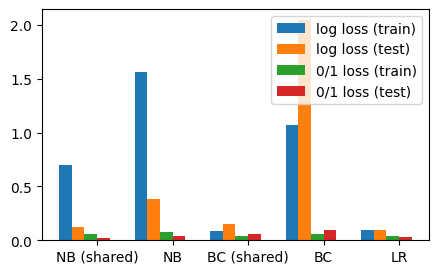

In [27]:
models = [nb_shared, nb, bc_shared, bc, log]
model_names = ['NB (shared)', 'NB', 'BC (shared)', 'BC', 'LR']
plt.subplots(1, 1, figsize=(5, 3))
plot_model_performances(models, model_names, breast_cancer_x_train, breast_cancer_x_test, breast_cancer_y_train, breast_cancer_y_test)
plt.legend()
plt.show()

Which of the models performs best in terms of train and test performance?

 Here the best is calculated through minimum log loss.We can clealy see that for our case the best model is BC(shared) which is the Bayes Classifier with shared covariance.This is the case for train and test set. However LR is pretty close.Although Naive Bayes does not perform as wel. Full variance Naive Bayes has higher error compared to the other models
Log loss value is used because it penalizes based on the degree of misclassification by providing the log likelihood

<div class="alert alert-block alert-warning">

#### II Implement an experiment where you test the performance for increasing training sizes ofN = 5, 10, . . . , 500. For each N sample 10 training sets of the corresponding size, fit allmodels, and record training and test errors
 <a class="anchor" name="tesincrease"></a>
    
</div>

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
def calculate_model_performances(models, model_names, x_train, x_test,  y_train,y_test):
    train_01_losses = []
    train_log_losses = []
    test_01_losses = []
    test_log_losses = []

    for i, model in enumerate(models):
        train_01_losses.append(zero_one_loss(y_train, model.predict(x_train)))
        train_log_losses.append(log_loss(y_train, model.predict_proba(x_train)))
        test_01_losses.append(zero_one_loss(y_test, model.predict(x_test)))
        test_log_losses.append(log_loss(y_test, model.predict_proba(x_test)))
    return train_01_losses, train_log_losses, test_01_losses, test_log_losses

Approach:

First we will define all the loss set along with corresponding index list.

For each training sizes we will sample 10 training set. These set will be same for all models.

train_01_losses_set, train_log_losses_set, test_01_losses_set, test_log_losses_set containing loss values for different models at different training set sizes and iterations.

we will have lists train_01_index_list, train_log_index_list, test_01_index_list, test_log_index_list with the indices of the models with the minimum losses.

We will do this for our training sizes range(5, 505, 5) for 10 sets of training

In [31]:
training_sizes = range(5, 505, 5)
model_names = ["Naive Bayes Shared", "Naive Bayes Full", "Bayesian Shared", "Bayesian Full", "Logistic Regression"]

train_01_losses_set = np.zeros((len(training_sizes), len(model_names),  len(range(10))))
train_log_losses_set = np.zeros((len(training_sizes), len(model_names),  len(range(10))))
test_01_losses_set = np.zeros((len(training_sizes), len(model_names),  len(range(10))))
test_log_losses_set = np.zeros((len(training_sizes), len(model_names), len(range(10))))
train_01_index_list = []
train_log_index_list = []
test_01_index_list = []
test_log_index_list = []

for j, training_size in enumerate(training_sizes):
 for i in range(10):
  x_train, x_test, y_train, y_test = train_test_split(breast_cancer.data, breast_cancer.target, train_size=training_size, shuffle=True, random_state=None)
      #Naive bayes shared
  nb_shared = BayesianClassifier(shared_cov=True, cond_ind=True).fit(x_train, y_train)
      #Naive bayes full
  nb = BayesianClassifier(shared_cov=False, cond_ind=True).fit(x_train, y_train)
      #Bayes Shared
  bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False).fit(x_train, y_train)
      #Bayes Full
  bc = BayesianClassifier(shared_cov=False, cond_ind=False).fit(x_train, y_train)
      #Logistic Regression
  log = LogisticRegression(max_iter = 10000).fit(x_train, y_train)
  models = [nb_shared, nb, bc_shared, bc, log]

  #Compute performance
  train_01_losses, train_log_losses, test_01_losses, test_log_losses=calculate_model_performances(models, model_names, x_train, x_test,  y_train,y_test)
  #store loss based on number of train size and current train set value
  train_01_losses_set[j, :, i] = train_01_losses
  train_log_losses_set[j, :, i] = train_log_losses
  test_01_losses_set[j, :, i] = test_01_losses
  test_log_losses_set[j, :, i] = test_log_losses
  #Store minimum index
  train_01_min_index = np.argmin(train_01_losses_set[j,:,i])
  train_01_index_list.append(train_01_min_index)
  train_log_min_index = np.argmin(train_log_losses_set[j,:,i])
  train_log_index_list.append(train_log_min_index)
  test_01_min_index = np.argmin(test_01_losses_set[j,:,i])
  test_01_index_list.append(test_01_min_index)
  test_log_min_index = np.argmin(test_log_losses_set[j,:,i])
  test_log_index_list.append(test_log_min_index)



In [32]:
# counting frequency then placed in a set
print(f'Best model for train_01 is {model_names[max(set(train_01_index_list), key=train_01_index_list.count)]}')
print(f'Best model for train_log is {model_names[max(set(train_log_index_list), key=train_log_index_list.count)]}')
print(f'Best model for test_01 is {model_names[max(set(test_01_index_list), key=test_01_index_list.count)]}')
print(f'Best model for test_log is {model_names[max(set(test_log_index_list), key=test_log_index_list.count)]}')

Best model for train_01 is Bayesian Shared
Best model for train_log is Logistic Regression
Best model for test_01 is Bayesian Shared
Best model for test_log is Logistic Regression


Thus using the approach we get the best models

<div class="alert alert-block alert-warning">

#### III Create suitable plots that compare the mean train and test performances of all models as a function of training size
 <a class="anchor" name="createplot"></a>
    
</div>

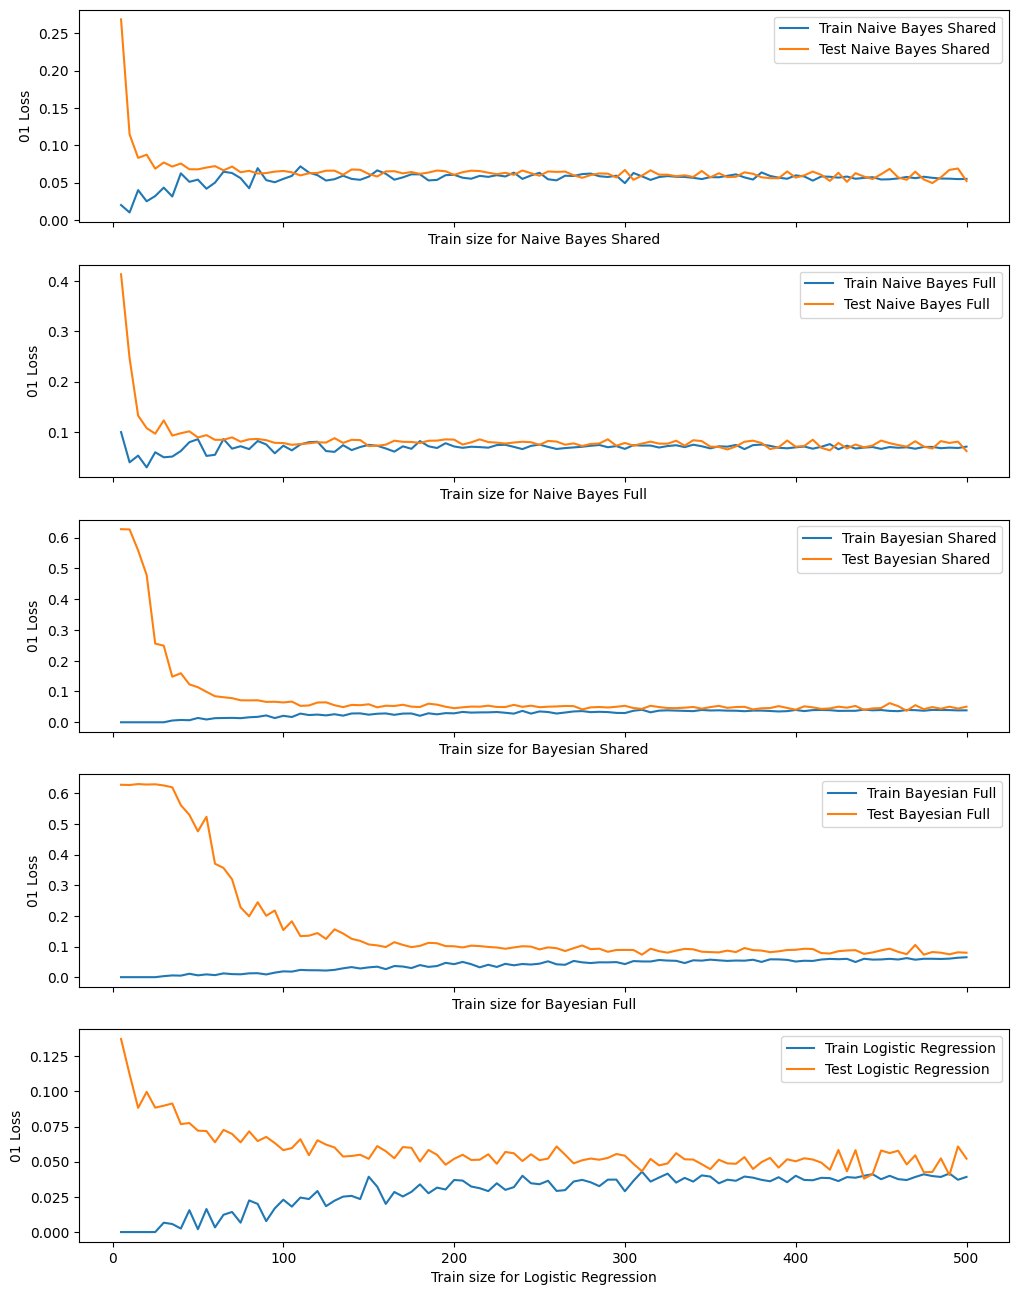

In [34]:
# 01 loss method
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=len(model_names), figsize=(12, 16), sharex=True)

for i, model_name in enumerate(model_names):
    ax = axes[i]
    ax.plot(training_sizes, train_01_losses_set[:, i].mean(axis=1), label=f'Train {model_name}')
    ax.plot(training_sizes, test_01_losses_set[:, i].mean(axis=1), label=f'Test {model_name}')
    ax.set_xlabel(f'Train size for {model_name}')
    ax.set_ylabel('01 Loss')
    ax.legend()

plt.show()

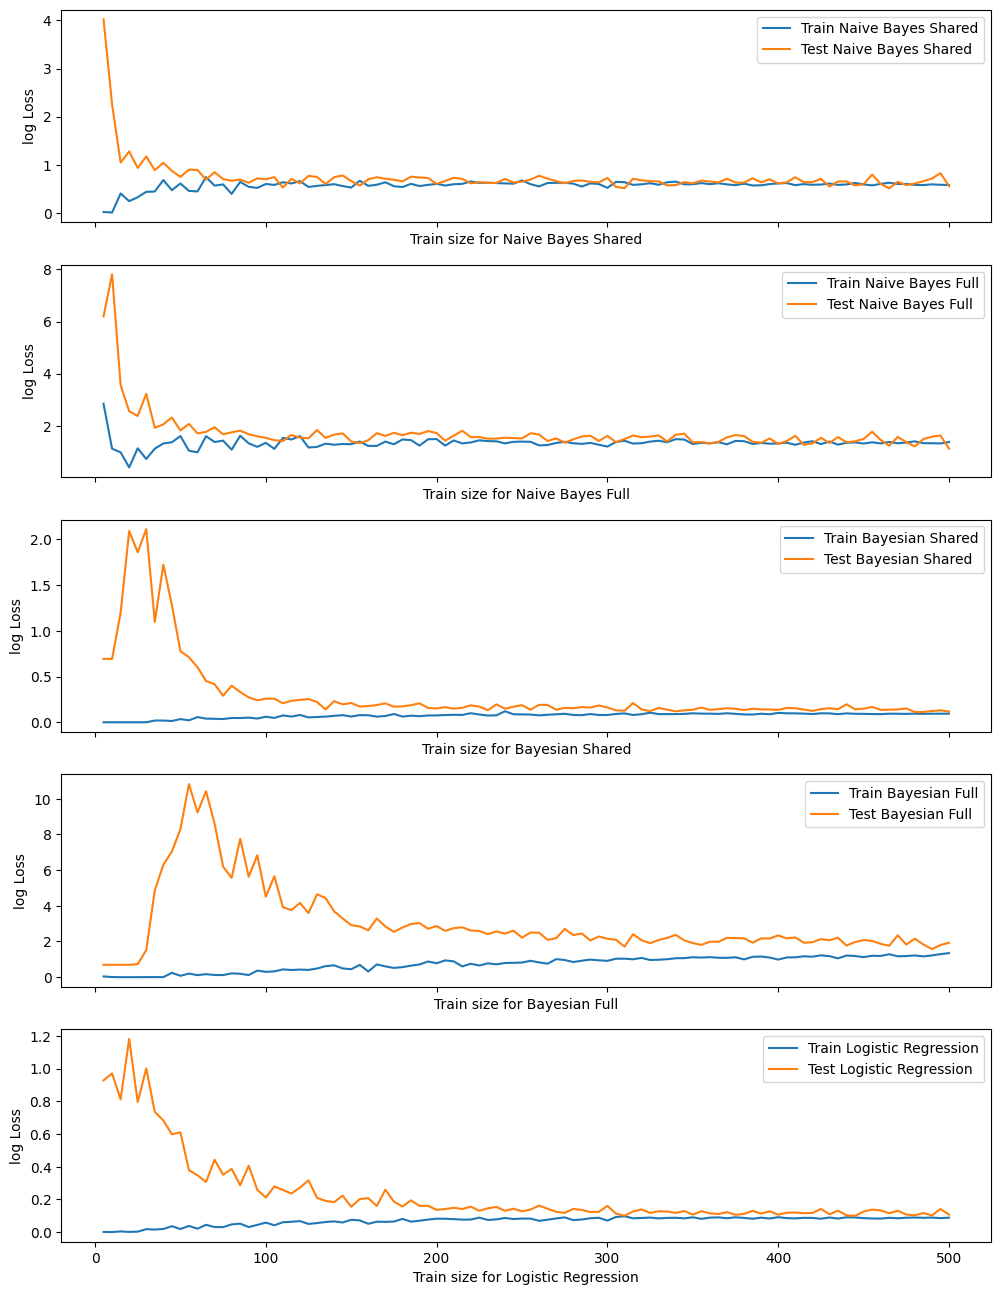

In [35]:
# log loss method
fig, axes = plt.subplots(nrows=len(model_names), figsize=(12, 16), sharex=True)

for i, model_name in enumerate(model_names):
    ax = axes[i]
    ax.plot(training_sizes, train_log_losses_set[:, i].mean(axis=1), label=f'Train {model_name}')
    ax.plot(training_sizes, test_log_losses_set[:, i].mean(axis=1), label=f'Test {model_name}')
    ax.set_xlabel(f'Train size for {model_name}')
    ax.set_ylabel('log Loss')
    ax.legend()

plt.show()

<div class="alert alert-block alert-warning">

#### IV Formulate answers to the following questions:
 <a class="anchor" name="form"></a>
    
</div>

a What happens to each classifiers train and test performance when the number of training
data points is increased?

As the training data increases bog log loss and 01loss starts performing better on unseen test dataset by minimising these loss. Having big amount of data helps all the models perform better performance at test set.

b Which classifier is best suited when the training set is small, and which is best suited
when the training set is big?

Naive Bayes tend to perform well on smaller dataset which we can also observe from the graphs above especially shared covariance

The rate of minimization of errors is high for logistic. Hence for bigger dataset we can use logistic regression as it is exected to improve with more data. Also Bayes Classifier can be used as the nature of bias classifier is to capture more parameters. However we should note so that the model does not become too complex and overfit

c Justify your observations by providing some speculations and possible reasons.

Naive Bayes demonstrates efficient parameter usage by assuming conditional independence between features given the target, which is advantageous when dealing with smaller datasets to prevent overfitting. Here features can easily be calculated using max likelihod.Thus it can estimate class conditional probabilities. However, this assumption may not always hold in complex real-world data as we will need the prior distribution.

Logistic Regression, while versatile, may require more data due to its use of all input features and the assumption of linear relationships. It using a sigmoid function to map 0 and 1. Thus more dataset will allow it to perform better on unseen data





References

1. Activity 1 2 3 from tutorial
2. data:
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html,
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html ,
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html

3. Total Conditional Probability:
https://corporatefinanceinstitute.com/resources/data-science/total-probability-rule/#:~:text=The%20Total%20Probability%20Rule%20(also,probabilities%20of%20several%20distinct%20events.

4. Conditional and Bayes rule:
https://stats.libretexts.org/Courses/Saint_Mary's_College_Notre_Dame/MATH_345__-_Probability_(Kuter)/2%3A_Computing_Probabilities/2.2%3A_Conditional_Probability_and_Bayes'_Rule

5. Change to one dimension flat array: https://numpy.org/doc/stable/reference/generated/numpy.ravel.html

6. knn regressor:
https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/

7. Analysis and markdown guide:
https://chat.openai.com/

8.Ridge regression help:
https://www.springboard.com/blog/data-science/ridge-regression-python/


